In [ ]:
 У нас имеется база данных в кикхаусе, куда ежедневно записываются данные по пользователям ленты новостей.
Лента новостей представляет из себя посты с возможностью их просматривать, лайкать, и также отправлять сообщения
друг другу. Действия по ленте новостей это like и view, действия по месссенджеру заполняются отдельной схемой в БД
и включают просто сообщения, кому и когда. В целом, лента и мессенджер составляют некое приложение, которое мы 
хотим развивать, наполняя новыми пользователями и поддерживая их активность.

In [ ]:
'''Из-за повышения активности пользователей, сервера часто перегружаются.
Наша задача спрогнозировать, как изменится активность пользователей в течение ближайшего месяца.
Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. 
Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые
вы включите в модель?
Постройте модель и провалидируйте её. Хватает ли у нас данных для бэктестинга с текущей задачей?
Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). 
Проинтерпретируйте её результаты. Если есть какие-то важные ограничения по выводу – не забудьте
их тоже указать.
Стоит также учесть, что  с 2025-01-17 по 2025-01-23 проходил Флэшмоб, целью которого было повышение
активности пользователей, и в этот период метрики могли иметь иное распределение.

In [ ]:
В качестве метрики для прогнозирования  возьмем действия которые непосредственно количественно выражают
активность пользователей - лайки, просмотры, также сообщения.
А в качестве регрессора возьмем DAU - потому что вероятно, эта метрика тоже будет изеняться при 
повышении активности.

In [1]:
import orbit # пакет для прогнозирования временных рядов
from orbit.models import DLT # один из вариантов модели
#для рисования предсказаний
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components 
#общие штуки для кручения данных
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# arviz Предназначенная для визуализации и анализа результатов байесовского 
# статистического моделирования (анализ сходимости цепей MCMC)
import arviz as az 

In [2]:
# Строка подключения к кликхаус
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'database':'simulator_20250120',
    'user':'student',
    'password':'dpo_python_2020'}
# Запрос исходной таблицы ленты новостей из БД для понимания структуры таблицы
feed = """
SELECT *
FROM {db}.feed_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""
# Запрос исходной таблицы мессенджера из БД для понимания структуры таблицы
messenger = """
SELECT *
FROM {db}.message_actions 
WHERE toDate(time) >= toDate('2025-01-03') and toDate(time) < toDate('2025-01-04')"""

In [5]:
# Наша исходная таблица ленты новостей
df_table_feed = ph.read_clickhouse(feed, connection=connection)
df_table_feed.head(5)

,user_id,post_id,action,time,gender,age,country,city,os,source,exp_group
0,12827,2004,like,2025-01-03 00:00:00,1,43,Turkey,İzmir,Android,ads,2
1,20565,1942,like,2025-01-03 00:00:00,0,23,Russia,Moscow,iOS,ads,4
2,114053,1915,view,2025-01-03 00:00:00,1,56,Russia,Kirov,Android,organic,3
3,115273,1984,view,2025-01-03 00:00:00,1,21,Russia,Moscow,iOS,organic,3
4,122707,1850,view,2025-01-03 00:00:01,1,25,Russia,Mirnyy,iOS,organic,1


In [6]:
# Наша исходная таблица мессенджера
df_table_messenger = ph.read_clickhouse(messenger, connection=connection)
df_table_messenger.head(5)

,user_id,receiver_id,time,source,exp_group,gender,age,country,city,os
0,1405,107098,2025-01-03 00:00:00,ads,0,1,27,Estonia,Tallinn,iOS
1,113395,113523,2025-01-03 00:00:00,organic,1,0,18,Russia,Novosibirsk,Android
2,1405,5791,2025-01-03 00:00:01,ads,0,1,27,Estonia,Tallinn,iOS
3,4554,110714,2025-01-03 00:00:01,ads,2,0,14,Russia,Bratsk,iOS
4,5953,110714,2025-01-03 00:00:01,ads,0,1,33,Russia,Saint Petersburg,iOS


In [7]:
# Запрос данных всех действий лайк + просмотры , DAU - за 3 месяца
query_feed = '''
SELECT 
    toDate(time) as date,
    count(distinct user_id) as DAU,
    count(action) as action
FROM 
    simulator_20250120.feed_actions
WHERE date >= toDate('2024-12-07')
  AND date <= toDate('2025-03-07')
GROUP BY date
ORDER BY date
'''
# Запрос количества сообщений
query_mess = '''
SELECT toDate(time) as date,
       count(receiver_id) as mess_sent
FROM simulator_20250120.message_actions
GROUP by date'''

In [11]:
# Поместим данные в датафремы 
df_feed = ph.read_clickhouse(query_feed, connection=connection)
df_mess = ph.read_clickhouse(query_mess, connection=connection)
# Соединим наши датафремы в один, и сложим колонки лайк+просмотры и сообщения
activity = df_feed.merge(df_mess, how='inner', left_on='date', right_on='date')
activity['total_act'] = activity['action'] + activity['mess_sent']
activity.head(5)

,date,DAU,action,mess_sent,total_act
0,2024-12-07,878,9163,3226,12389
1,2024-12-08,2238,75586,12895,88481
2,2024-12-09,3105,126484,12897,139381
3,2024-12-10,3721,142796,12897,155693
4,2024-12-11,4617,208958,12898,221856


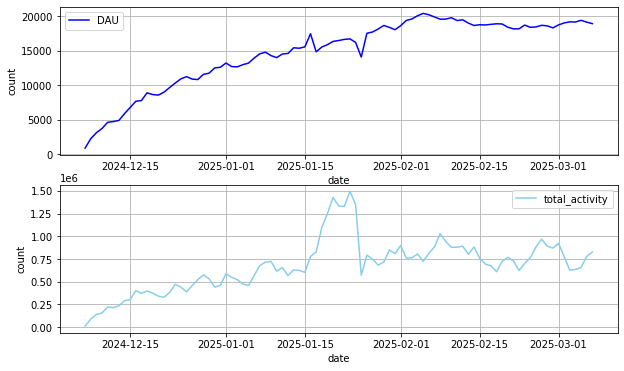

In [4]:
# Посмотрим на наши данные, построим графики
fig, axis = plt.subplots(2, 1, figsize=(10, 6))
axis[0].plot(activity['date'], activity['DAU'], color='blue', label='DAU')
axis[0].set_xlabel('date')
axis[0].set_ylabel('count')
axis[0].legend()
axis[0].grid()
axis[1].plot(activity['date'], activity['total_act'], color='skyblue', label='total_activity')
axis[1].set_xlabel('date')
axis[1].set_ylabel('count')
axis[1].legend()
axis[1].grid()

In [ ]:
''' На графике активности видно что в период  флешмоба с 2025-01-17 по 2025-01-23 была аномальная активность
    плюс пару дней на восстановление активности'''

In [5]:
# Отметим дни флешмоба как аномальные, пометив их 1 - затем это можно добавить в модель
flashmob = ((activity['date'] >= pd.to_datetime('2025-01-17')) & 
            (activity['date'] <= pd.to_datetime('2025-01-23')))
activity['anomaly'] = np.where(flashmob, 1, 0 )
activity.head(5)

,date,DAU,action,mess_sent,total_act,anomaly
0,2024-12-07,878,9163,3226,12389,0
1,2024-12-08,2238,75586,12895,88481,0
2,2024-12-09,3105,126484,12897,139381,0
3,2024-12-10,3721,142796,12897,155693,0
4,2024-12-11,4617,208958,12898,221856,0


In [6]:
# Для улучшения качества модели стандартизируем наши данные
dau_std = activity.DAU.std()
dau_mean = activity.DAU.mean()
act_std = activity.total_act.std()
act_mean = activity.total_act.mean()
activity['DAU_norm'] = (activity['DAU'] - dau_mean) / dau_std
activity['act_norm'] = (activity['total_act'] - act_mean) / act_std
activity.head(5)

,date,DAU,action,mess_sent,total_act,anomaly,DAU_norm,act_norm
0,2024-12-07,878,9163,3226,12389,0,-2.819755,-2.294004
1,2024-12-08,2238,75586,12895,88481,0,-2.544252,-2.030516
2,2024-12-09,3105,126484,12897,139381,0,-2.368618,-1.854262
3,2024-12-10,3721,142796,12897,155693,0,-2.243831,-1.797778
4,2024-12-11,4617,208958,12898,221856,0,-2.062323,-1.568672


In [7]:
# По заданию у нас нет 3 месяцев данных, есть только 2 месяца а третий нужно предсказать
activity_train = activity.loc[activity['date'] <= pd.to_datetime('2025-02-07'), :]


In [ ]:
Нам нужно выбрать лучшую модель, поэтому мы попробуем различные комбинации параметров:
1. Модель с линейным трендом (это значит наши данные имеют линейный рос - параметр по умолчанию)
2. Модель с логлинейным трендом (резкий рост/падение в начале, а потом плавное замедление)
3. Модель линейный тренд + DAU как регрессор
4. Модель логлинейный тренд + DAU как регрессор
5. Модель линейный тренд + DAU как регрессор + аномалии флешмоба
6. Модель логлинейный тренд + DAU как регрессор + аномалии флешмоба

In [8]:
simple_lin = DLT(response_col='act_norm',          # колонка с метрикой
                 date_col='date',                  # колонка с датой
                 estimator='stan-mcmc',            # метод оценки модели 
                 global_trend_option='linear',     # тренд в данных 
                 num_warmup=10000,                 # количество семплов для разогрева алгоритма
                 num_sample=10000)                 # количество семплов для работы    

simple_loglin = DLT(response_col='act_norm',         
                 date_col='date',                  
                 estimator='stan-mcmc',            
                 global_trend_option='loglinear',     
                 num_warmup=10000,                 
                 num_sample=10000)

DAU_lin = DLT(response_col='act_norm',         
                 date_col='date',                  
                 estimator='stan-mcmc',            
                 global_trend_option='linear',
                 regressor_col=['DAU_norm'], regressor_sign=['+'],  # указавыет регрессор и его направление
                 num_warmup=10000,                                  # поскольку полагаем что DAU тоже растет
                 num_sample=10000)                                  # при росте активности

DAU_loglin = DLT(response_col='act_norm',         
                 date_col='date',                  
                 estimator='stan-mcmc',            
                 global_trend_option='loglinear',
                 regressor_col=['DAU_norm'], regressor_sign=['+'], 
                 num_warmup=10000,                 
                 num_sample=10000)

anomaly_lin = DLT(response_col='act_norm',         
                 date_col='date',                  
                 estimator='stan-mcmc',            
                 global_trend_option='linear',
                 regressor_col=['DAU_norm', 'anomaly'], regressor_sign=['+', '+'],  # доп регрессор и его знак
                 num_warmup=10000,                     # поскольку наша аномали вызывала именно рост активности
                 num_sample=10000)

anomaly_loglin = DLT(response_col='act_norm',         
                 date_col='date',                  
                 estimator='stan-mcmc',            
                 global_trend_option='loglinear',
                 regressor_col=['DAU_norm', 'anomaly'], regressor_sign=['+', '+'], 
                 num_warmup=10000,                 
                 num_sample=10000)

In [ ]:
# Положим все модели в список и запустим цикл по списку для обучения каждой
model_list = [simple_lin, simple_loglin, DAU_lin, DAU_loglin, anomaly_lin, anomaly_loglin]
for model in model_list:
    model.fit(activity_train)

In [10]:
# Теперь нам надо создать датафрейм с горизонтом прогнозирования - то есть теми датами, 
# которые мы хотим предсказать. Для этого есть вспомогательный метод .make_future_df()
# делаем прогноз на месяц = 30 дней для первый двух моделей без регрессора
futur = model_list[0].make_future_df(periods=30)
predict_1 = model_list[0].predict(futur)
predict_2 = model_list[1].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

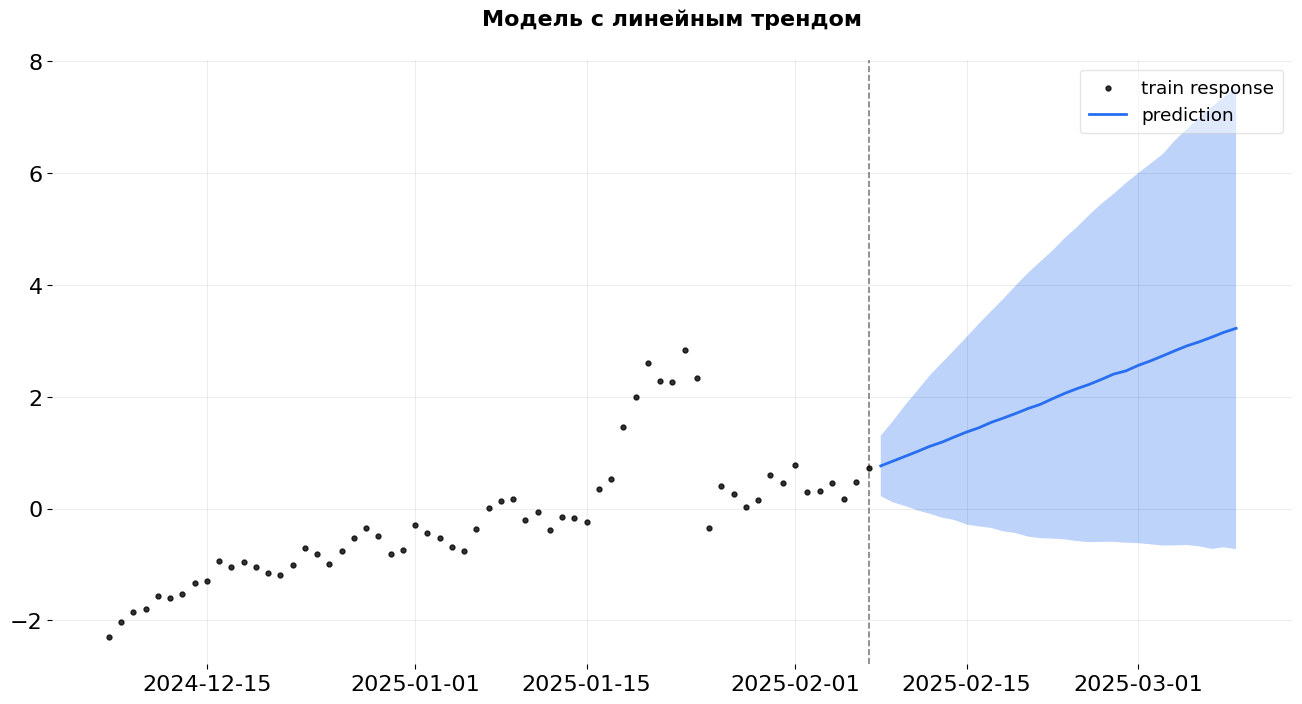

In [11]:
# Рисуем наш прогноз для первой модели с линейным трендом
_ = plot_predicted_data(activity_train, predict_1, 'date', 'act_norm', title='Модель с линейным трендом')

In [ ]:
''' 
Модель с линейным трендом дает очень большой ДИ как в сторону роста так и падения,
поскольку мы хотим предсказать месяц по двум месяцам, ну и очевидно данные имеют линейный рост
'''

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

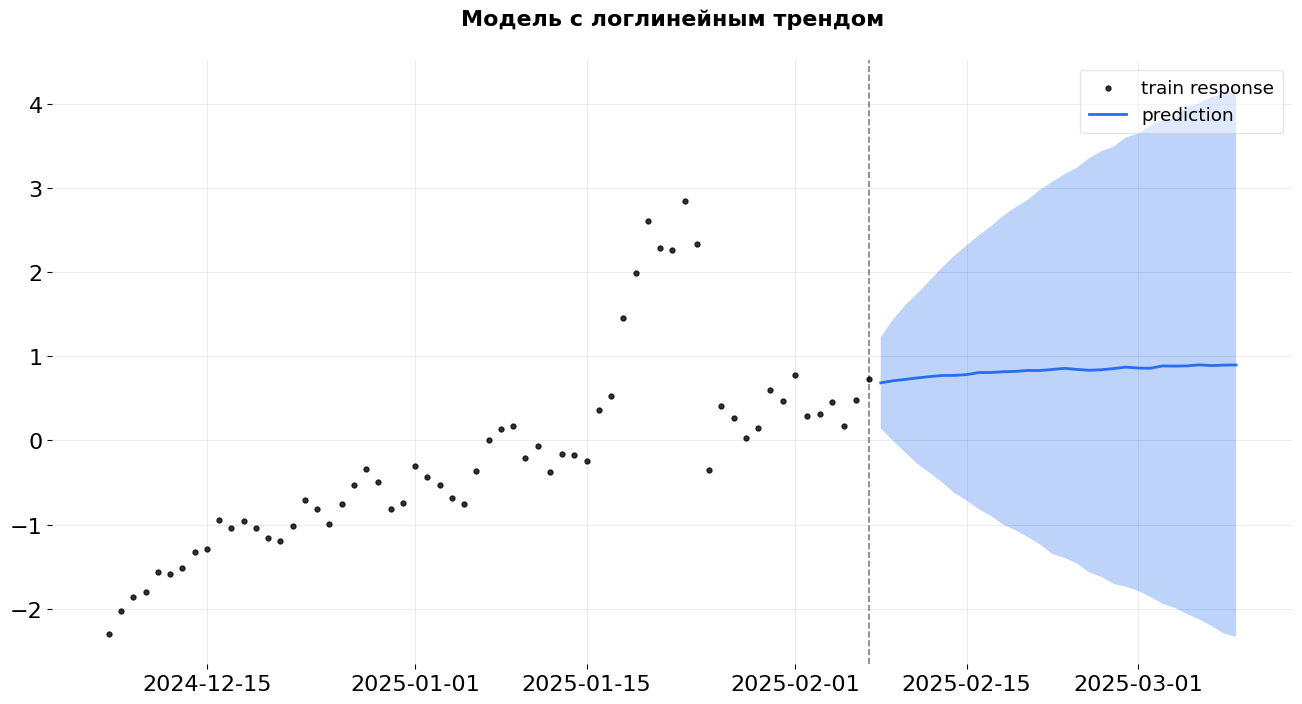

In [12]:
# Рисуем наш прогноз для второй модели с логлинейным трендом
_ = plot_predicted_data(activity_train, predict_2, 'date', 'act_norm', title='Модель с логлинейным трендом')

In [ ]:
'''
Модель с логлинейным трендом дает такие же широкие ДИ но при этом сам тренд в предсказании
имеет почти прямую линию - очень медленный рост'''

In [13]:
# Поскольку чтоб добавить регрессор в модель, нужно знать его значение на период предсказания
# сделаем прогноз для DAU
DAU_model = DLT(response_col='DAU_norm',
                date_col='date',
                estimator='stan-mcmc',
                global_trend_option='linear',
                num_warmup=10000,
                num_sample=10000)

In [ ]:
# Обучаем модел на данных
DAU_model.fit(activity_train)

In [15]:
# прогнозируем
DAU_predict = DAU_model.predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

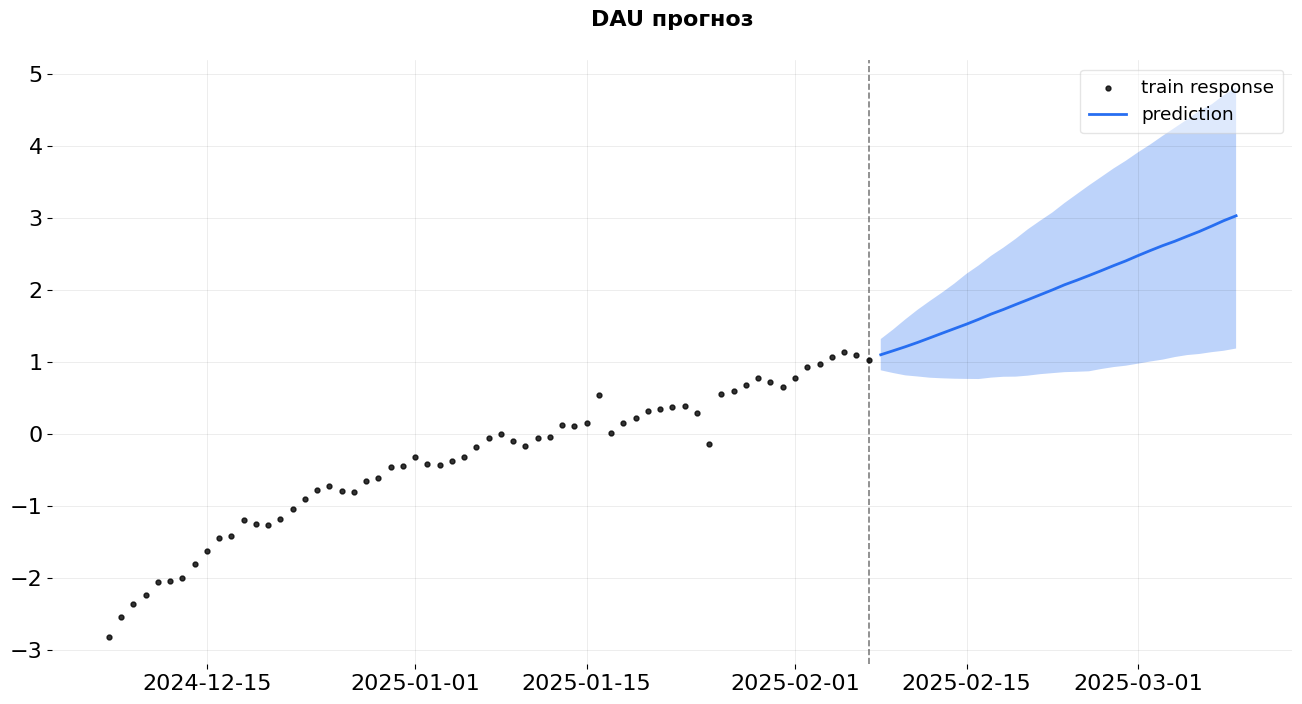

In [16]:
# Рисуем наш прогноз DAU
_ = plot_predicted_data(activity_train, DAU_predict, 'date', 'DAU_norm', title='DAU прогноз')

In [17]:
# Добавим в нашу таблицу для прогноза столбец с данными регрессора из прогноза
futur['DAU_norm'] = DAU_predict.prediction
futur.head(4)

,date,DAU_norm
0,2025-02-08,1.098839
1,2025-02-09,1.153839
2,2025-02-10,1.209797
3,2025-02-11,1.269356


In [18]:
predict_3 = model_list[2].predict(futur)
predict_4 = model_list[3].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

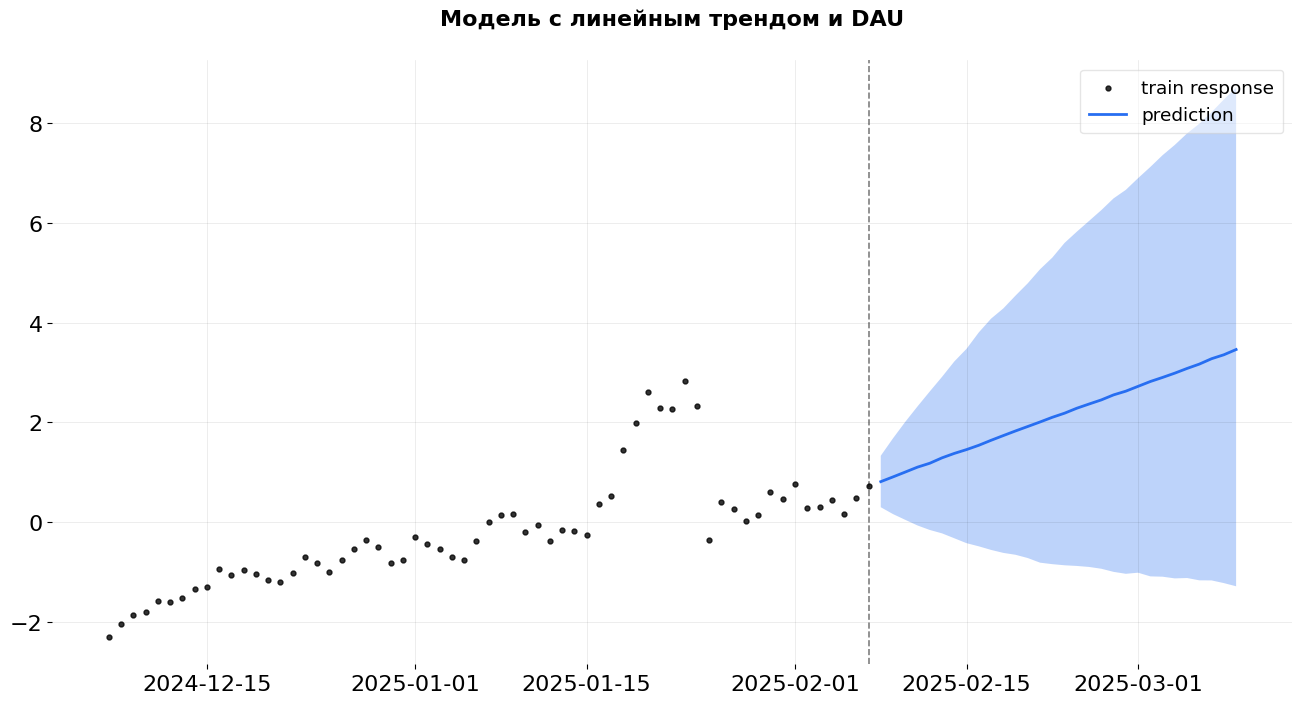

In [19]:
# Рисуем наш прогноз для 3 модели с регрессором DAU
_ = plot_predicted_data(activity_train, predict_3, 'date', 'act_norm', title='Модель с линейным трендом и DAU')

In [ ]:
'''
Добавление регрессора только уведичило ДИ прогноза и ничего более'''

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

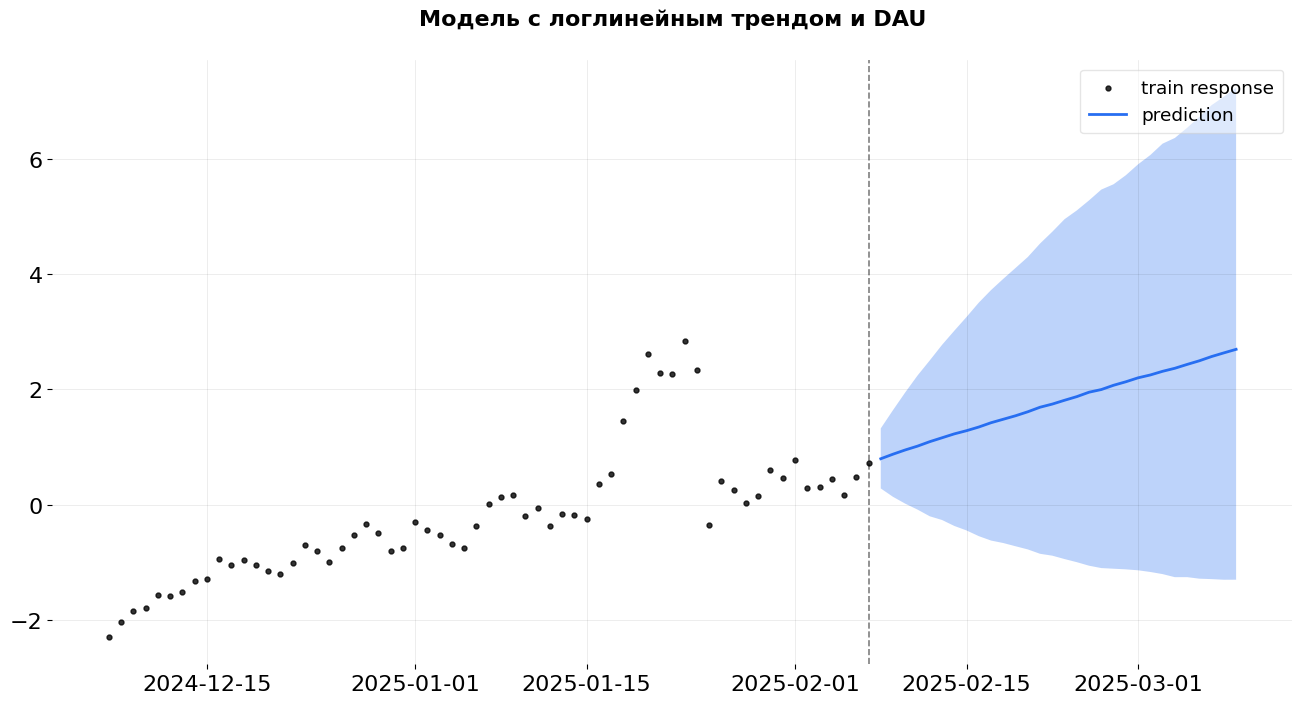

In [20]:
# Рисуем наш прогноз для 4 модели с регрессором DAU
_ = plot_predicted_data(activity_train, predict_4, 'date', 'act_norm', title='Модель с логлинейным трендом и DAU')

In [ ]:
'''
Добавлене регрессора в модель с логлинейным трендом увеличило градиент роста предсказания метрики,
и немного увеличило ДИ '''

In [21]:
# Пробуем добавить наш столбец с аномалиями в виде флешмоба. А т.к. в период прогноза аномалий не планируется
# то просто столбик с 0
futur['anomaly'] = 0
futur.head(4)

,date,DAU_norm,anomaly
0,2025-02-08,1.098839,0
1,2025-02-09,1.153839,0
2,2025-02-10,1.209797,0
3,2025-02-11,1.269356,0


In [23]:
# Строим прогноз для последних двух моделей с регрессором и аномалиями
predict_5 = model_list[4].predict(futur)
predict_6 = model_list[5].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

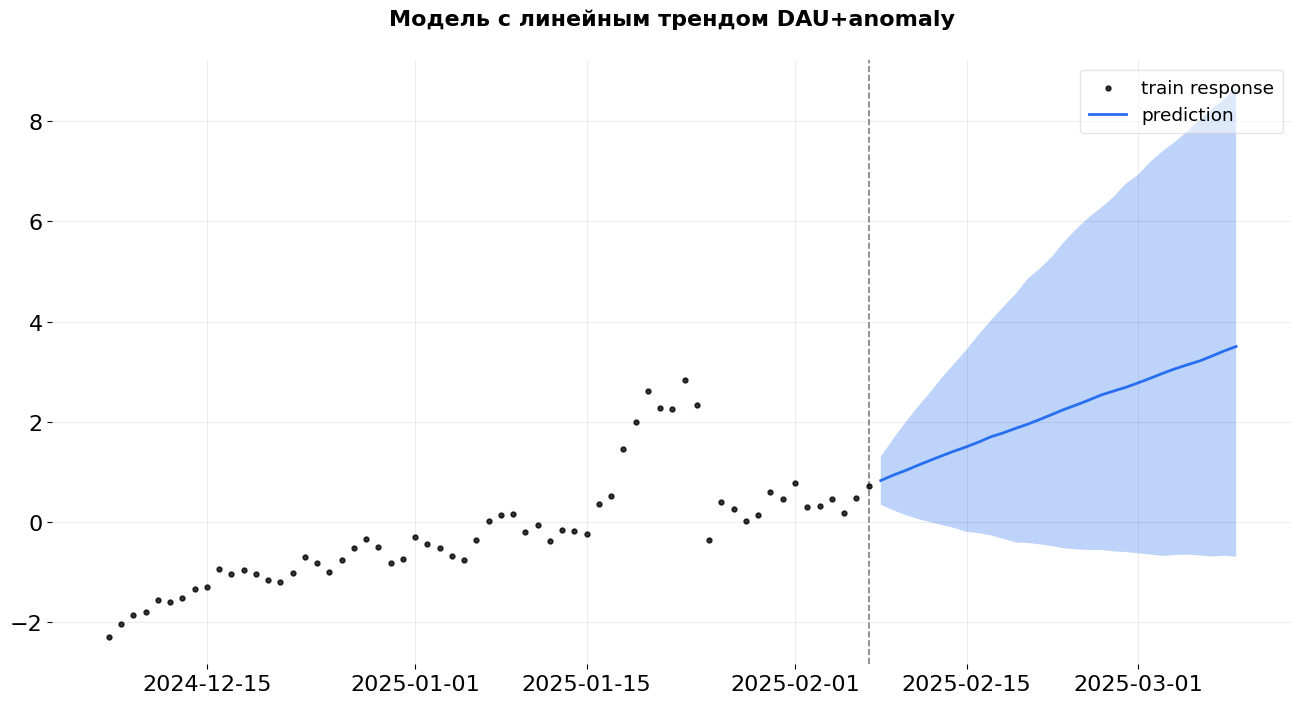

In [24]:
# Рисуем наш прогноз для 5 модели с регрессором DAU  и аномалиями
_ = plot_predicted_data(activity_train, predict_5, 'date', 'act_norm', 
                        title='Модель с линейным трендом DAU+anomaly')

In [ ]:
''' Никаких изменений относительно модели просто с DAU'''

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

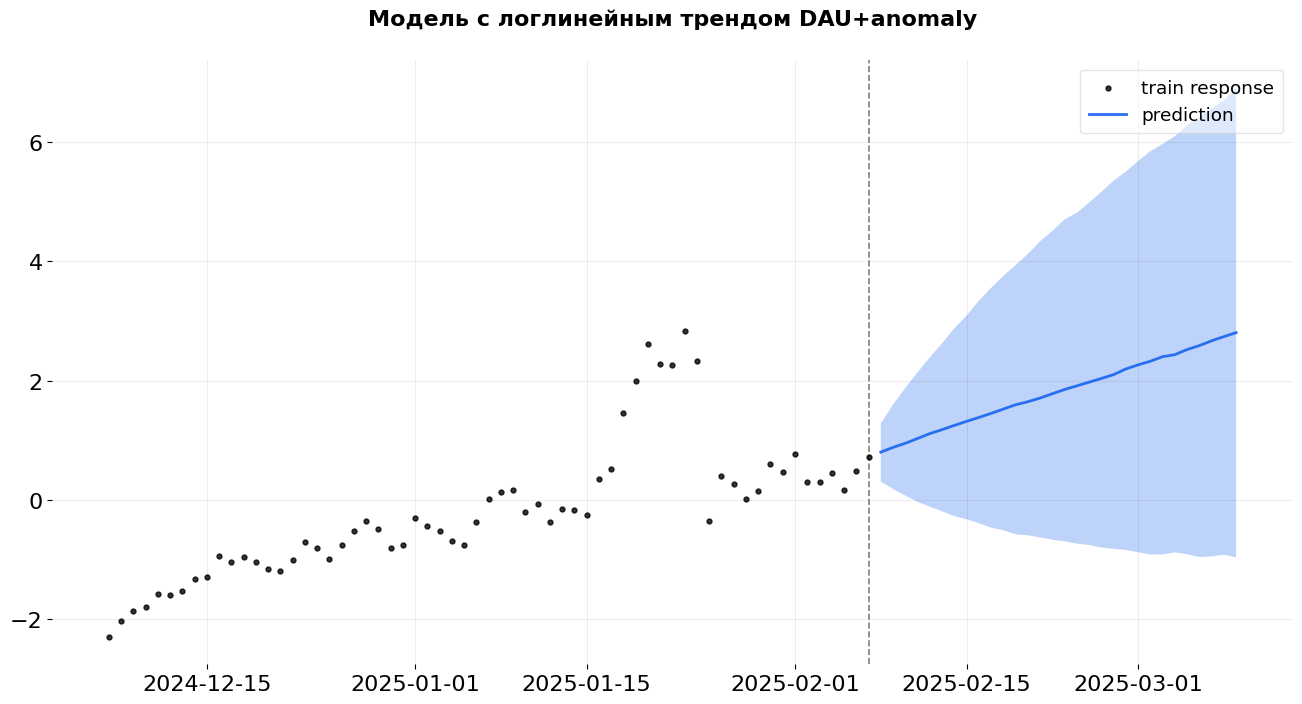

In [25]:
# Рисуем наш прогноз для 6 модели с регрессором DAU  и аномалиями
_ = plot_predicted_data(activity_train, predict_6, 'date', 'act_norm', 
                        title='Модель с логлинейным трендом DAU+anomaly')

In [ ]:
''' Никаких изменений относительно модели с логлинейным трендом с DAU'''

In [ ]:
''' Оценим модели через бэктестинг, но поскольку у нас прогноз на месяц а данных всего два месяца, бэктест
 нормально не получиться сделать в несколько шагов, поэтому допускаем что наши данные стабильны и характер
 недельных изменений в данных такой же как месячных. С этим допущением будем делать бэктест на неделю'''

In [ ]:
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
test_list_exp = []                # список в который поместим объеткы бектеста с оценками модели
for model in model_list:
    becktest = BackTester(
        model=model,               # наша модель
        df=activity_train,         # датафрейм для обучения
        min_train_len=7,           # самый маленький кусочек данных, с которого начинается обучение
        incremental_len=7,         # на сколько происходит прирост тренировочных данных
        forecast_len=7,            # горизонт пронозирования
        window_type="expanding")   # тип окна - расширяющийся
    becktest.fit_predict()         # обучение модели
    test_list_exp.append(becktest) 

In [27]:
# Циклом проходим по каждому объекту бэктеста и получаем таблицу с оценками
# к  этой таблице добавляем столбец с номером модели, и канкатинируем все таблицы
exp_df = []
for number, tester in enumerate(test_list_exp):
    insert_df = tester.score()                     # получаем оценки из объекта бектеста
    insert_df.insert(0, 'model_number', number + 1)# делаем столбец с номером модели, т.к. номера от 0, добавляем +1
    exp_df.append(insert_df)                       # добавляем все таблицы в список
exp_df = pd.concat(exp_df)                         # конкатенируем таблицы
exp_df = exp_df.set_index('model_number')          # устанавливаем идекс как номер модели

In [28]:
exp_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,0.897402,False
1,wmape,0.870714,False
1,mape,4.060440,False
1,mse,1.047988,False
1,mae,0.666701,False


In [ ]:
# Для скользящего окна
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга
test_list_roll = []                # список в который поместим объеткы бектеста с оценками модели
for model in model_list:
    becktest = BackTester(
        model=model,               # наша модель
        df=activity_train,         # датафрейм для обучения
        min_train_len=7,           # самый маленький кусочек данных, с которого начинается обучение
        incremental_len=7,         # на сколько происходит прирост тренировочных данных
        forecast_len=7,            # горизонт пронозирования
        window_type="rolling")   # тип окна - скользящий
    becktest.fit_predict()         # обучение модели
    test_list_roll.append(becktest) 

In [30]:
roll_df = []
for number, tester in enumerate(test_list_roll):
    insert_df = tester.score()                     # получаем оценки из объекта бектеста
    insert_df.insert(0, 'model_number', number + 1)# делаем столбец с номером модели, т.к. номера от 0, +1
    roll_df.append(insert_df)                       # добавляем все таблицы в список
roll_df = pd.concat(roll_df)                         # конкатенируем таблицы
roll_df = roll_df.set_index('model_number') 

In [31]:
 for metric in exp_df.metric_name.unique(): # Проходим циклом по унакальном названиям оценок
    # Получаем минимальное значение по каждой из оценок    
    min_value =  exp_df[exp_df['metric_name']==metric].metric_values.min()
    # Берем индекс (номер модели) минимальных оценок - если несколько список
    n = exp_df[(exp_df['metric_values']==min_value) & (exp_df['metric_name']==metric)].index.tolist()
    # Печатаем 
    print(f'минимальный {metric} = {min_value} имеет модель номер {n}')

минимальный smape = 0.75836287247706 имеет модель номер [2]
минимальный wmape = 0.8418648798488342 имеет модель номер [2]
минимальный mape = 4.028770003059437 имеет модель номер [2]
минимальный mse = 0.9942599484201701 имеет модель номер [2]
минимальный mae = 0.6446110154684421 имеет модель номер [2]
минимальный rmsse = 2.067696756254799 имеет модель номер [2]


In [32]:
 for metric in roll_df.metric_name.unique(): # Проходим циклом по унакальном названиям оценок
    # Получаем минимальное значение по каждой из оценок    
    min_value =  roll_df[roll_df['metric_name']==metric].metric_values.min()
    # Берем индекс (номер модели) минимальных оценок - если несколько список
    n = roll_df[(roll_df['metric_values']==min_value) & (roll_df['metric_name']==metric)].index.tolist()
    # Печатаем 
    print(f'минимальный {metric} = {min_value} имеет модель номер {n}')

минимальный smape = 0.804465139174824 имеет модель номер [2]
минимальный wmape = 0.8911393455449594 имеет модель номер [2]
минимальный mape = 4.768112951876383 имеет модель номер [6]
минимальный mse = 1.1233091218029316 имеет модель номер [2]
минимальный mae = 0.6823401857062452 имеет модель номер [2]
минимальный rmsse = 2.1977916378358806 имеет модель номер [2]


In [ ]:
'''По всем оценкам лидирует модель 2 - без регрессора с логлинейным трендом.'''

In [ ]:
''' Посмотрим на информационные критерии - показатель качества модели мера относительного качества модели. 
Их задача — отобрать модель с максимальной предсказательной способностью и минимумом предикторов
чем меньше критерий тем лучше модель'''
for model in model_list:           # Если мы используем алгоритм MCMC, то нужен дополнительный шаг
    model.fit_wbic(activity_train) # Обучаем наши модели данным методом

In [34]:
# Проходим циклом по моделям достаем оценку и номер модели
for num, model in enumerate(model_list):
    print(f'Модель {num+1}, WBIC = {model.get_wbic()}')

Модель 1, WBIC = 67.21005288680988
Модель 2, WBIC = 66.30535661231983
Модель 3, WBIC = 60.80029496589587
Модель 4, WBIC = 59.54167312369134
Модель 5, WBIC = 57.26884820575222
Модель 6, WBIC = 55.81971601926404


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

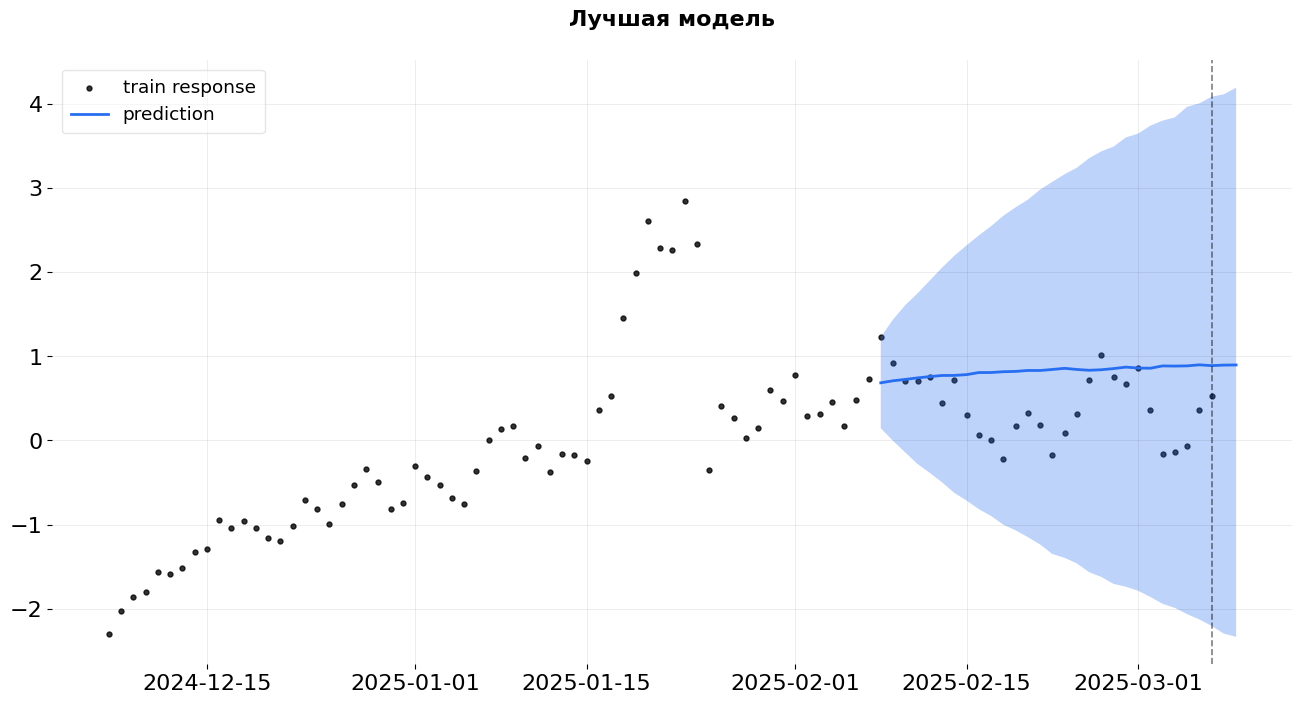

In [36]:
# Рисуем наш прогноз для второй модели но с данными трех месяцев - посмотрим визуально как хорошо
# модель предсказала наши данные
_ = plot_predicted_data(activity, predict_2, 'date', 'act_norm', title='Лучшая модель')

In [37]:
# Есть еще способ проверить качество модлели визуально по сходимости цепей МСМС для этого можно
# визуализировать некоторые параметры модели
# relabel=True, автоматически генерируются понятные названия для параметров вместо технических
# permute=False сохраняет исходный порядок выборок (не перемешивает цепи) - удобно для анализа сходимости
# на выходе словарь содержащий апостериорные выборки для параметров 
params = model_list[1].get_posterior_samples(permute=False, relabel=True) # достаём информацию о параметрах
params.keys() # их названия

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 'gt_sum', 'gb', 'gl', 'loglk'])

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>],
       [<Axes: title={'center': 'gb'}>, <Axes: title={'center': 'gb'}>],
       [<Axes: title={'center': 'gl'}>, <Axes: title={'center': 'gl'}>]],
      dtype=object)

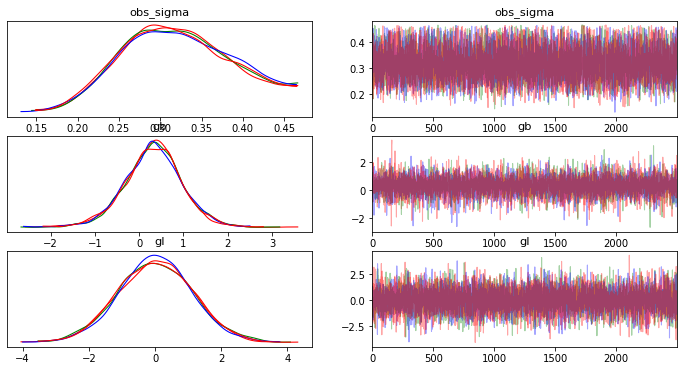

In [38]:
# Из библиотеки Arviz строим графики сходимости цепей МСМС - это графическая оценка эффективности модели
az.plot_trace(params, #словарь с параметрами
              var_names=['obs_sigma', 'gb', 'gl'],
             chain_prop={'color' : ['r', 'g', 'b']}) #названия параметров, на которые мы смотрим
# 'obs_sigma'  характеризует разброс данных вокруг предсказанных значений модели
# 'gb' это коэффициент, определяющий, как быстро растет или падает тренд
# 'gl' Текущий уровень временного ряда. Это базовая величина, вокруг которой колеблются наблюдения
#      с учетом тренда и сезонности
# Если все цепи (разные цвета) перемешаны и имеют схожие распределения, это означает, что алгоритм сходится.

In [ ]:
'''
Все цепи визуально сходятся отлично
'''

In [40]:
# Теперь возьмем данные исходные но на период предсказания
df_futur = activity.loc[activity['date'] > pd.to_datetime('2025-02-07'), ['date', 'DAU', 'total_act']]\
.reset_index(drop=True)
df_futur.head()

,date,DAU,total_act
0,2025-02-08,19554,1028844
1,2025-02-09,19572,941705
2,2025-02-10,19768,877717
3,2025-02-11,19363,879682
4,2025-02-12,19466,891241


In [41]:
# Переведем все предсказанные данные всех моделей обратно в исходные величины из нормализованных
df_futur['predict1'] = (predict_1.prediction * act_std) + act_mean
df_futur['predict2'] = (predict_2.prediction * act_std) + act_mean
df_futur['predict3'] = (predict_3.prediction * act_std) + act_mean
df_futur['predict4'] = (predict_4.prediction * act_std) + act_mean
df_futur['predict5'] = (predict_5.prediction * act_std) + act_mean
df_futur['predict6'] = (predict_6.prediction * act_std) + act_mean
df_futur.head()

,date,DAU,total_act,predict1,predict2,predict3,predict4,predict5,predict6
0,2025-02-08,19554,1028844,894778.402316,872330.240223,9.099989e+05,904692.351352,9.136322e+05,906676.694871
1,2025-02-09,19572,941705,919781.023877,879263.903482,9.374926e+05,927624.944080,9.442142e+05,929471.634529
2,2025-02-10,19768,877717,944571.464600,883940.883032,9.655666e+05,948874.179129,9.708348e+05,949505.947633
3,2025-02-11,19363,879682,969452.002753,889221.383663,9.939712e+05,967951.565178,1.000617e+06,972621.024807
4,2025-02-12,19466,891241,995946.977773,893619.260550,1.016459e+06,990348.762558,1.028929e+06,996372.670374


<Axes: >

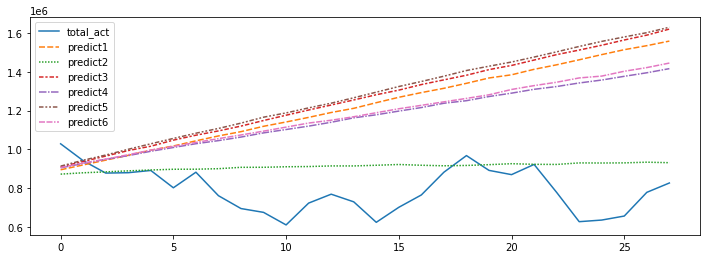

In [50]:
# Нарисуем предсказанные данные всех моделей и настоящие данные для сравнения
plt.figure(figsize=(12, 4))
sns.lineplot(df_futur.filter(regex=r'^date|^total\w*|^pred\w*'))# берем только необходимые столбцы

In [43]:
df_futur['DAU_predict'] = (DAU_predict.prediction * dau_std) + dau_mean

<Axes: >

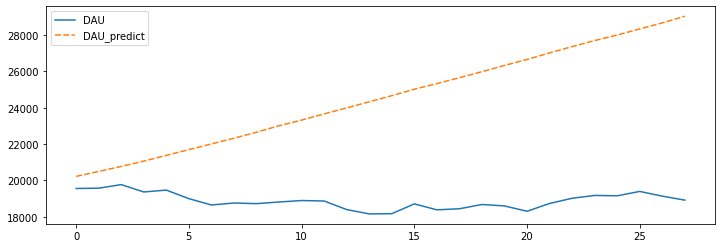

In [51]:
# Нарисуем предсказанные данные регрессора DAU, и его реальные значения в период предсказания
plt.figure(figsize=(12, 4))
sns.lineplot(df_futur.filter(regex=r'^date|^DAU\w*'))# берем только необходимые столбцы

In [ ]:
'''
На графиках четко видно что именно модель 2 самая близкая к реальным данным - что подтверждается
и бектестингом. Несмотря на то что по информационным критериям ледирует модель 6, как мы видим тут 
она очень далека от истины, вероятно потому что информационных критерии оценивают не то насколько хорошо
предсказывает модель данные, а скорее качество модели. Поэтому в данном случае можно оставить 2 модель.
Хотя интуитивно кажется что добавление регрессора улучшит модель, но поскольку рельных данных регрессора на
период предсказания нет - мы вынуждены их предсказать - и как мы видим предсказание слишком далеко уходит 
от реальных данных, что в свою очередь скорее всего и стало причиной больших ошибок на моделях с регрессором
'''